seed: (226925827, -150932899, -488349278, -694912861, -715275105, -543979961)
iteration 79/80                     


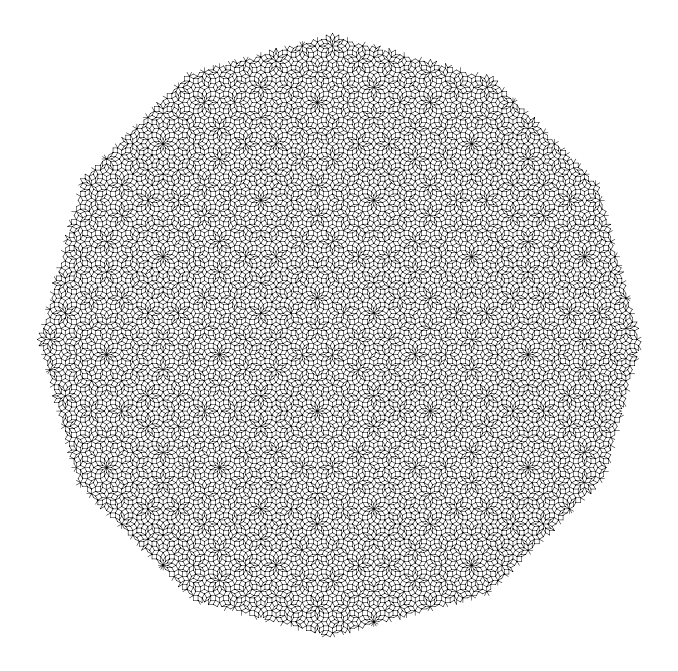

In [1]:
from scipy.spatial.distance import squareform, pdist
from pylab import *
from numpy import * 

N  = 6                     # Dimension of crystal
Ndepth = 80                 # Number of search iterations
θ  = linspace(0,pi,N+1)[1:] # Arrange basis vectors evenly on [0,π)
A  = array([cos(θ),sin(θ)]) # Convert from complex notation
Ai = pinv(A)

def plotpoints(p):
    u  = Ai.T@p
    D  = squareform(pdist(p.T))
    e  = {tuple(sorted(e)) for e in zip(*where(abs(D-1)<1e-6))}
    xy = concatenate([[u[:,a],u[:,b],[NaN,NaN]] for a,b in e])
    plot(*xy.T,lw=0.5,color='k')
    tight_layout()
    axis("equal")
    axis("off")

# Directions in which to search
D = int64(concatenate([eye(N),-eye(N)])) 

# Matrix to rotate a lattice point π/N in 2D plane
S = zeros((N,N))
S[ -1,0 ] = -1
S[:-1,1:] = eye(N-1)

# Generic caching intersection check function
# Map all points to first quadrant and memoize
def cached_crystal_checker(check):
    # Cache results to save time (memoization)
    cache = {}
    def f(q):
        # Convert test point to immutable tuple for cache key
        k = tuple(int64(q)) 
        if not k in cache:
            # Recompute intersection test if not in cache
            # Use symmetry: reduce tests to points in 1st sector
            h = angle([1,1j]@A@q)
            cache[k]=check(q) if 0<=h<=(pi/N*1.1) else f(S@q)
        return cache[k]
    f.__cache__ = cache
    return f

# Get slopes and spacing of boundary lines
m = 1/tan(θ[:-1])
d = 1/sin(θ[:-1])

@cached_crystal_checker
def intersects_cut(p,eps=1e-3,maxiter=10):
    p = int64(p)
    # Evaluate upper/lower bounds
    lp,up = p[:-1]-0.5, p[:-1]+0.5
    def feasibility_surface(p,x):
        u,l = x*m+up*d, x*m+lp*d
        y   = np.max(l)-np.min(u)
        dy  = m[argmax(l)]-m[argmin(u)]
        return y,dy
    # Initial bounds and feasability checks
    # If either bound satisfies, success
    # If better point not in bounds, fail
    x0,x1  = p[-1]-0.5, p[-1]+0.5
    y0,dy0 = feasibility_surface(p,x0)
    y1,dy1 = feasibility_surface(p,x1)
    if y0 < 0 or y1 < 0: return True
    if dy0>=0 or dy1<=0: return False
    for i in range(maxiter):
        # Guess min by following slope at bounds
        xm = (y1-y0-dy1*x1+dy0*x0)/(dy0-dy1)
        assert xm>=x0-eps
        assert xm<=x1+eps
        # Midpoint works? still feasible? 
        ym,dym = feasibility_surface(p,xm)
        if ym<0:   return True
        if dym==0: return False
        # Binary search: move inward if not done
        if dym<0:
            # If better point not in bounds, fail
            if dym>=0 or abs(x0-xm)<eps: return False
            x0,y0,dy0 = xm,ym,dym
        else:
            if dym<=0 or abs(x1-xm)<eps: return False
            x1,y1,dy1 = xm,ym,dym
    # Should have returned succes/fail before getting here
    raise RuntimeError("Maximum iterations exceeded: p=%s"%p)
    
# Random seed to nucleate crystal
seed = tuple(int64(0.5+Ai@(randint(-2**31,2**31,2))))
if not intersects_cut(seed):
    print('Seed doesn\'t intersect plane, searching nearby')
    searching = {seed}
    found = None
    for i in range(5):
        to_add    = set()
        to_search = {tuple(q) for p in searching for q in D+p}
        for q in to_search:
            if intersects_cut(q):
                found = q
                break
            else:
                to_add.add(q)
        searching |= to_add
    if found is None:
        print('Could not find a valid seed')
        assert 0
    else:
        seed = tuple(found)

print('seed:',seed)

'''
Would it be faster to test only those points that border two edges? 
'''

# Start with a seed point at zero and build outwards
# Iteratively search in each direction to add points
Q = {seed}
allQ = set() 
for i in range(Ndepth):
    Q = {tuple(q) for p in Q for q in D+p if intersects_cut(q)}-allQ
    allQ |= Q
    print('\riteration %d/%d'%(i,Ndepth),' '*20,end='',flush=True)
print('')

figure(figsize=(10,10))
plotpoints(array(list(allQ)).T)

In [2]:
lattice_points      = int64(list(allQ))
distances           = squareform(pdist(lattice_points))
edges_directed      = {tuple(e) for e in zip(*where(abs(distances)==1.0))}
edges_directed      = int32(list(edges_directed))
edge_lattice_points = lattice_points[int32(list(edges_directed)),:]
edge_lattice_deltas = diff(edge_lattice_points,1,1).squeeze()

from collections import defaultdict
edgemap = defaultdict(dict)
for (a,b) in edge_lattice_points:
    Δ = b-a
    edgemap[tuple(a)][tuple(Δ)] = tuple(b)

shiftL = eye(N,k=1,dtype='i4')
shiftL[-1,0] = -1
shiftR = int32(inv(shiftL))

def plot2(p,**kwargs):
    u = p@Ai
    u = concatenate([u,full((u.shape[0],1,2),NaN)],axis=1)
    u = u.reshape(u.shape[0]*u.shape[1],2).T
    plot(*u,**kwargs)

def fill2(p,color='k',**kwargs):
    u = p@Ai # Project to 2D
    x,y = u[:,:,0],u[:,:,1]
    polygons = [*zip(x,y,[color,]*len(x))]
    gca().fill(*concatenate(polygons))

In [8]:
deltas = {i:int32(matrix_power(shiftL,i)) for i in arange(-N,N+1)}

In [4]:
cycles = [[] for i in range(len(sequences))]
for edge in edge_lattice_points:
    for iseq,(color,sequence) in enumerate(sequences):
        a,b = edge
        Δ = b-a
        cycle = [a,b]
        for i,s in enumerate(sequence):
            Δ = deltas[s]@Δ
            c = cycle[-1] + Δ
            cycle.append(c)
            if not tuple(c) in allQ:
                break
        if i==len(sequence)-1:
            cycles[iseq].append(cycle)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(543979937.9082713, 543979985.1906366, -488349301.23330534, -488349253.9509401)

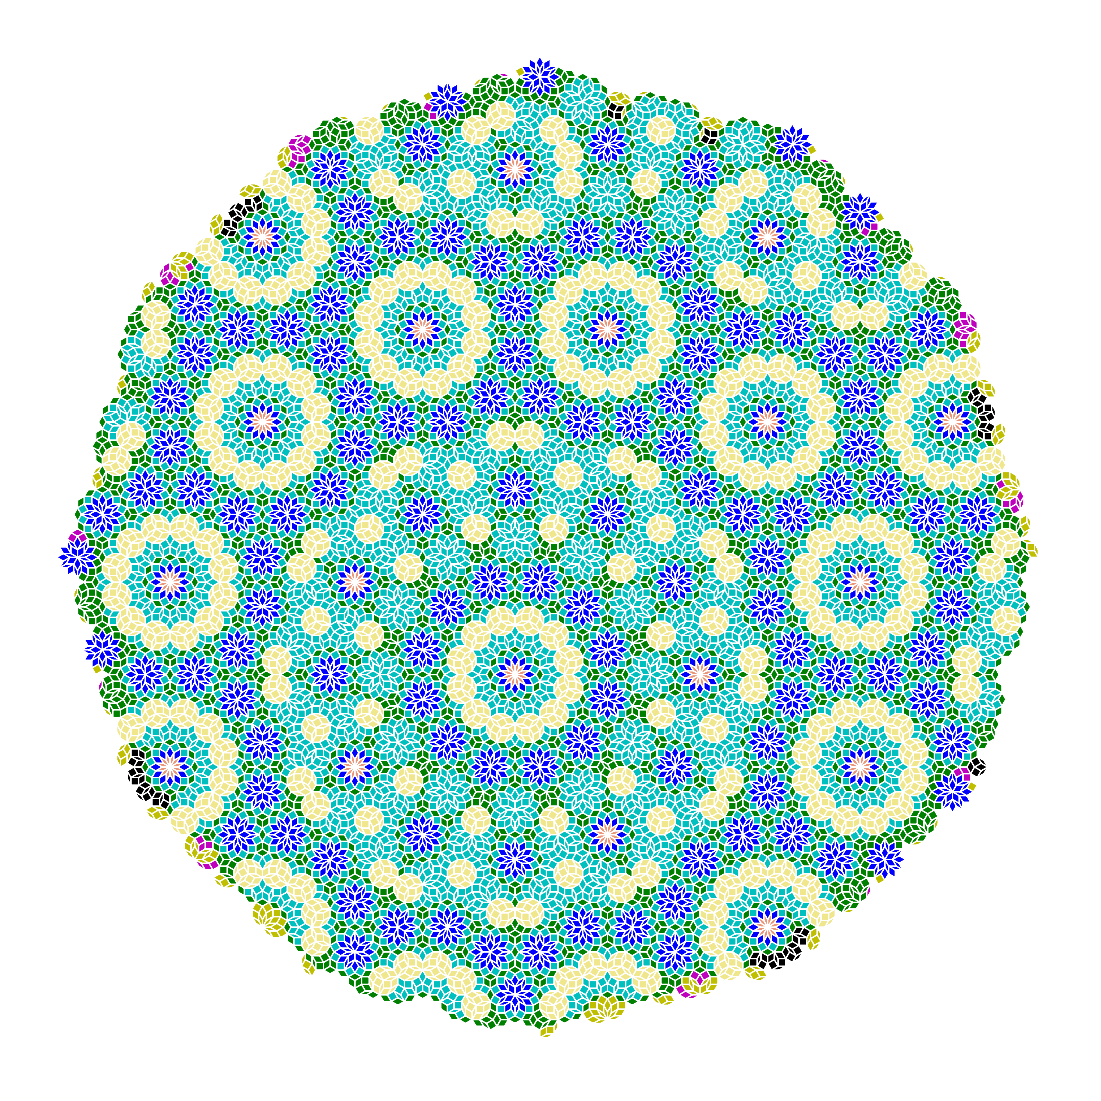

In [9]:
sequences = [
    ('k',[1,2,]*4),
    ('m',[1,1,1,1,2,]*2),
    ('y',[1,-2,]*12),
    ('g',[2,-3,]*12),
    ('c',[3,-4,]*12),
    ('b',[4,-5,]*12),
    ('darksalmon',[1,]*12),
    ('khaki',[1,1,1,3,]*2),
]

figure(figsize=(20,20))
for cc,(color,_) in zip(cycles,sequences):
    fill2(int64(cc),zorder=100,lw=1.5,color=color)
    
plot2(edge_lattice_points,lw=1,color='w')
#plot2(edge_lattice_points,lw=.4,color='k')

axis('square')
axis('off')

In [ ]:
'''
Can we use a priority queue? 
- Boundary set
- Test set is all adjacent to boundary ordered by descending multiplicity
- Test the top of the queue
  - If dead, move to 'banned' list, continue
  - If ok
    - 
'''